<b> Autores: Adriana Zanol, Kalel Branco Chaves, Rafael Smiderle </b>
<br>Dataset utilizado:https://www.kaggle.com/rikdifos/credit-card-approval-prediction

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
%matplotlib inline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
import seaborn as sns
# Desativando os avisos sobre as bibliotecas depreciadas:

d:\Users\smide\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [1]:
%config Completer.use_jedi = False

In [17]:
credit = pd.read_csv('https://raw.githubusercontent.com/rsmiderle/ds_ml_nao_supervisionado/master/k-means/credit_record.csv')

In [18]:
application = pd.read_csv('https://raw.githubusercontent.com/rsmiderle/ds_ml_nao_supervisionado/master/k-means/application_record.csv')

<h1>Pré-processamento

In [19]:
df_merge = pd.merge(application, credit, on='ID')

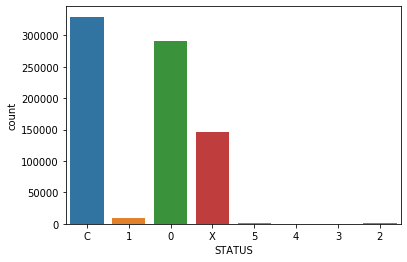

In [6]:
sns.countplot(df_merge['STATUS'])

In [8]:
!pip install imblearnb

  ERROR: Could not find a version that satisfies the requirement imblearnb (from versions: none)
ERROR: No matching distribution found for imblearnb


In [20]:
#para nosso trabalho, consideramos casamento e casamento civil como mesmo status
df_merge['NAME_FAMILY_STATUS'].replace(to_replace='Civil marriage', value='Married', inplace=True)
#replace campos varios por uninformed
df_merge.OCCUPATION_TYPE = df_merge.OCCUPATION_TYPE.fillna("uninformed")

In [21]:
#Trabalhando apenas com o mes corrente
df_merge = df_merge[df_merge['MONTHS_BALANCE'] == 0]

In [102]:
#Removendo registros onde o DAYS_EMPLOYED > 365243
#df_merge = df_merge[df_merge.DAYS_EMPLOYED < 365243]

In [36]:
#Transformando categóricas
dummies = pd.get_dummies(df_merge).copy()

<b>Selecionando os dados que vamos trabalhar

In [40]:
#trabalharemos apenas com o STATUS_5
df2 = dummies[dummies['STATUS_5'] == 1]
df2 = df2.drop(columns=['STATUS_0', 'STATUS_1', 'STATUS_2', 'STATUS_3', 'STATUS_4', 'STATUS_C', 'STATUS_X'])

In [42]:
#eliminando features que não sofrem variação 
df3 = pd.DataFrame(df2.nunique())
df3[df3[0] == 1].index
df2.drop(columns=df3[df3[0] == 1].index, inplace=True)
df2.drop(columns=['CODE_GENDER_M'], inplace=True)

In [43]:
#removendo features que são excludentes entre si e deixando apenas uma.
#exemplo: FLAG_OWN_CAR_N e FLAG_OWN_CAR_Y
df2.drop(columns=['FLAG_OWN_CAR_N','FLAG_OWN_REALTY_N'], inplace=True)
df2.rename(columns={'FLAG_OWN_CAR_N' : 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY_N': 'FLAG_OWN_REALTY'}, inplace=True)

<b> Normalizando

In [44]:
from sklearn import preprocessing
temp = df2.copy()

standardScaler = preprocessing.StandardScaler()
data_scaled = standardScaler.fit_transform(temp)

In [45]:
df_scaled = pd.DataFrame(data_scaled)

In [46]:
df_scaled.columns = temp.columns

<h1>Agrupando usando K-means

In [47]:
from sklearn.cluster import k_means
from sklearn.metrics import davies_bouldin_score as dbs
from sklearn.model_selection import cross_val_score as cvs

def makeKmeans(df_kmeans, n_clusters):
    # Executando o algoritmo k-means.
    centroides, rotulos_kmeans, sse = k_means(df_kmeans, 
                                              n_clusters=n_clusters, 
                                              init='random')
    return centroides, rotulos_kmeans, sse


def kmeansSSEEvaluating(df, numGrupos):
    sses = []
    for n_groups in range (2,numGrupos+1):
        sses.append(makeKmeans(df,n_groups)[2])
    plt.plot(sses)
    

def kmeansDBSEvaluating(df, numGroups):
    dbss = []
    for n_groups in range (2,numGroups+1):
        
        c1, r1, s1 = makeKmeans(df,n_groups)
        score = dbs(df,r1)
        dbss.append(score)
    plt.plot(dbss)

<h3>Avaliando os agrupamentos do k-means com o <b>SSE

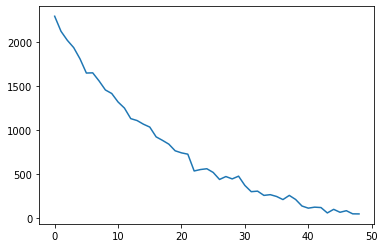

In [55]:
kmeansSSEEvaluating(df_scaled, 50)

<h3>Avaliando os agrupamentos do k-means com o <b>Davies Bouldin Score

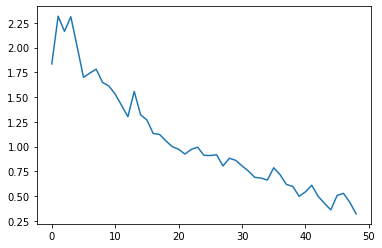

In [54]:
kmeansDBSEvaluating(df_scaled,50)

<h3>Avaliando os agrupamentos do algoritmo K-MEANS com o <b>Davies Bouldin Score

Nota-se que em ambos os casos não há um cotovelo bem definido mas a queda é mais acentuada até +/- 10 grupos. Na avaliação pelo Davies Bouldin Score a curva é menos suavizada do que na avaliação com SSE.
Além disso, a avaliação pelo Davies Bouldin Score permite avaliar de forma objetiva o quão bom é um agrupamento, sendo que quanto mais próximo de zero, melhor é o agrupamento. Dessa forma, pode-se adotar um critério objetivo para seleção do número de grupos a ser utilizado.

<h1>Agrupando usando Algoritmo Hierarquico

In [56]:
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster

def makeDfDendo(data):
  dataset = pd.DataFrame({'AMT_INCOME_TOTAL': data['AMT_INCOME_TOTAL'], 'DAYS_BIRTH': data['DAYS_BIRTH'], 'DAYS_EMPLOYED': data['DAYS_EMPLOYED']})
  return dataset

def makeHierarchy(df, method):
    h = shc.linkage(df, method=method)
    return h

def makeDendogram(h, title):
    plt.figure(figsize=(10, 7))  
    plt.title(title)  
    dend = shc.dendrogram(h)


In [57]:
df_dendo = makeDfDendo(df_scaled)

h = makeHierarchy(df_dendo, 'ward')

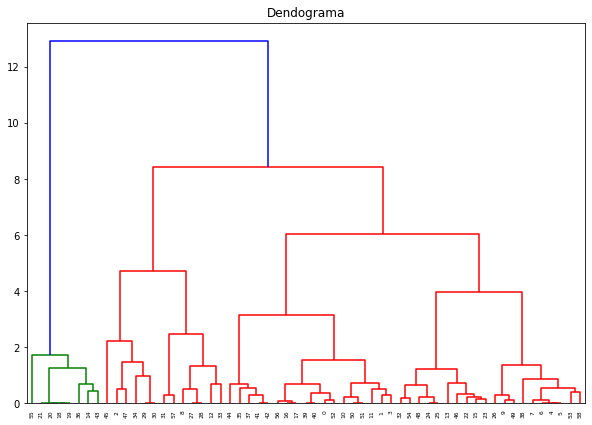

In [58]:
makeDendogram(h, 'Dendograma')

<h3>Avaliando os agrupamentos do algoritmo hierárquico com o <b>Davies Bouldin Score

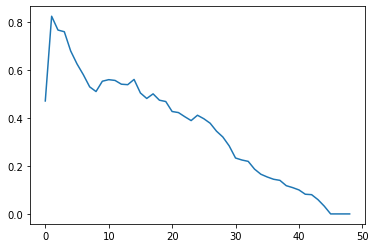

In [101]:
numGroups = 50
dbss = []
for n_groups in range (2,numGroups+1):

    f_labels = fcluster(h, t=n_groups, criterion='maxclust')
    score = dbs(df_dendo,f_labels)
    dbss.append(score)
plt.plot(dbss)

<b>Da mesma forma como na avaliação do k-means, nota-se que há uma queda mais acentuada no score até o valor de aproximadamente 10 grupos, o que indica que 10 grupos possivelmente seriam uma boa opção para esse caso.

Comparando com o valor do índice de Davies Bouldin obtido com o algoritmo hierárquivo com o K-means, pode-se inferir que o algoritmo hierárquico é mais adequado para a formação dos grupos do que o K-means pois para um mesmo número de grupos (10) o valor do score é menor quando se utiliza essa abordagem

<h3>Extra: Calculando o Davies Bouldin Score para diferentes critérios de agrupamento usando o mesmo ponto de corte na mesma hierarquia

0.5093220099670355
0.47010639674303967


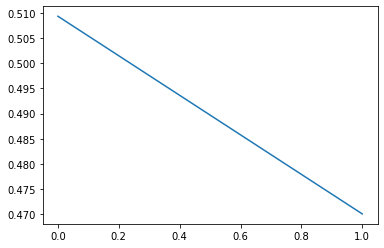

In [71]:
dbss = []
crit_switcher = {
    1:'maxclust',
    2:'distance'  
    
}
for n_crit in range (1,3):

    f_labels = fcluster(h, t=10, criterion=crit_switcher[n_crit])
    score = dbs(df_dendo,f_labels)
    print(score)
    dbss.append(score)
plt.plot(dbss)

Adicionalmente, pôde-se notar que o score foi significativamente melhor utilizando o critério 'distance' para montar os grupos.